In [1]:
# Prepare graph data...
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import namedtuple
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])
class GraphDataset():
    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)
def get_dataset(input_dir,n_files):
    return GraphDataset(input_dir, n_files)
def load_graph(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)
#Function to load X, Ri, Ro, Y.
def load_raw(graph_name,xyr):
    graph_ex=load_graph(graph_name)
    #Load raw data
    y=graph_ex.y
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    X=graph_ex.X
    if xyr=='X':
        return X
    elif xyr=='Ri':
        return Ri
    elif xyr=='Ro':
        return Ro
    else:
        return y

In [2]:
# Load X data of dimension Nv x 4(including color)
import os
import pandas as pd
dir_ = os.path.join(os.getcwd(), 'color')
#dir_ = os.path.join(os.getcwd(), 'coloredX')
file_path = os.path.join(dir_, "event000001000_g000.csv")
colorX = pd.read_csv(file_path)
print("features data loaded...")

features data loaded...


In [3]:
#Convenient representation of edge data 
#edges = [[i1,j1], [i2,j2], ... ]; i1, i2,... are outgoing-nodes, and j1, j2, ... are incoming-nodes
import json
graph='event000001000_g000'
with open("./networks/"+graph+".json", "r") as json_file:
        _,_,edges= json.load(json_file)
print("edge data loaded...")

edge data loaded...


In [5]:
# Prepare data for training (quantum circuits and labels)
y = load_raw('event000001000_g000.npz','y')
#Define Ys
Ys = []
Ys_01 = []
#Number of training samples
n_samples=10
#Regularization for binary loss
epsilon=0.01
#Number of vertices in each sample
cut=4
for i in range(n_samples):
    Y = np.array(y[cut*i:cut*(i+1)])  # True edge labels of dimension
    Ys_01.append(y[cut*i:cut*(i+1)])
    #Need to regularize Y to prevent Log(0) in loss function
    for i in range(len(Y)):
        if Y[i]==0:
            Y[i]+=epsilon
        else:
            Y[i]-=epsilon
    Ys.append(Y)
print("Ys prepared...")

Ys prepared...


In [9]:
#Vertices for each edge
graph_ex=load_graph('event000001000_g000.npz')
#Load raw data
Ri=graph_ex.Ri
Ro=graph_ex.Ro
Ri,Ro = Ri.T, Ro.T
Rio=Ri-Ro
Edges=np.matmul(Rio,colorX.values)
print("Edges vector constructed...")
#colored X data
Xs=[]
for i in range(n_samples):
    X=Edges[i*cut:(i+1)*cut].flatten()
    Xs.append(X)
print("Xs prepared...")

Edges vector constructed...
Xs prepared...


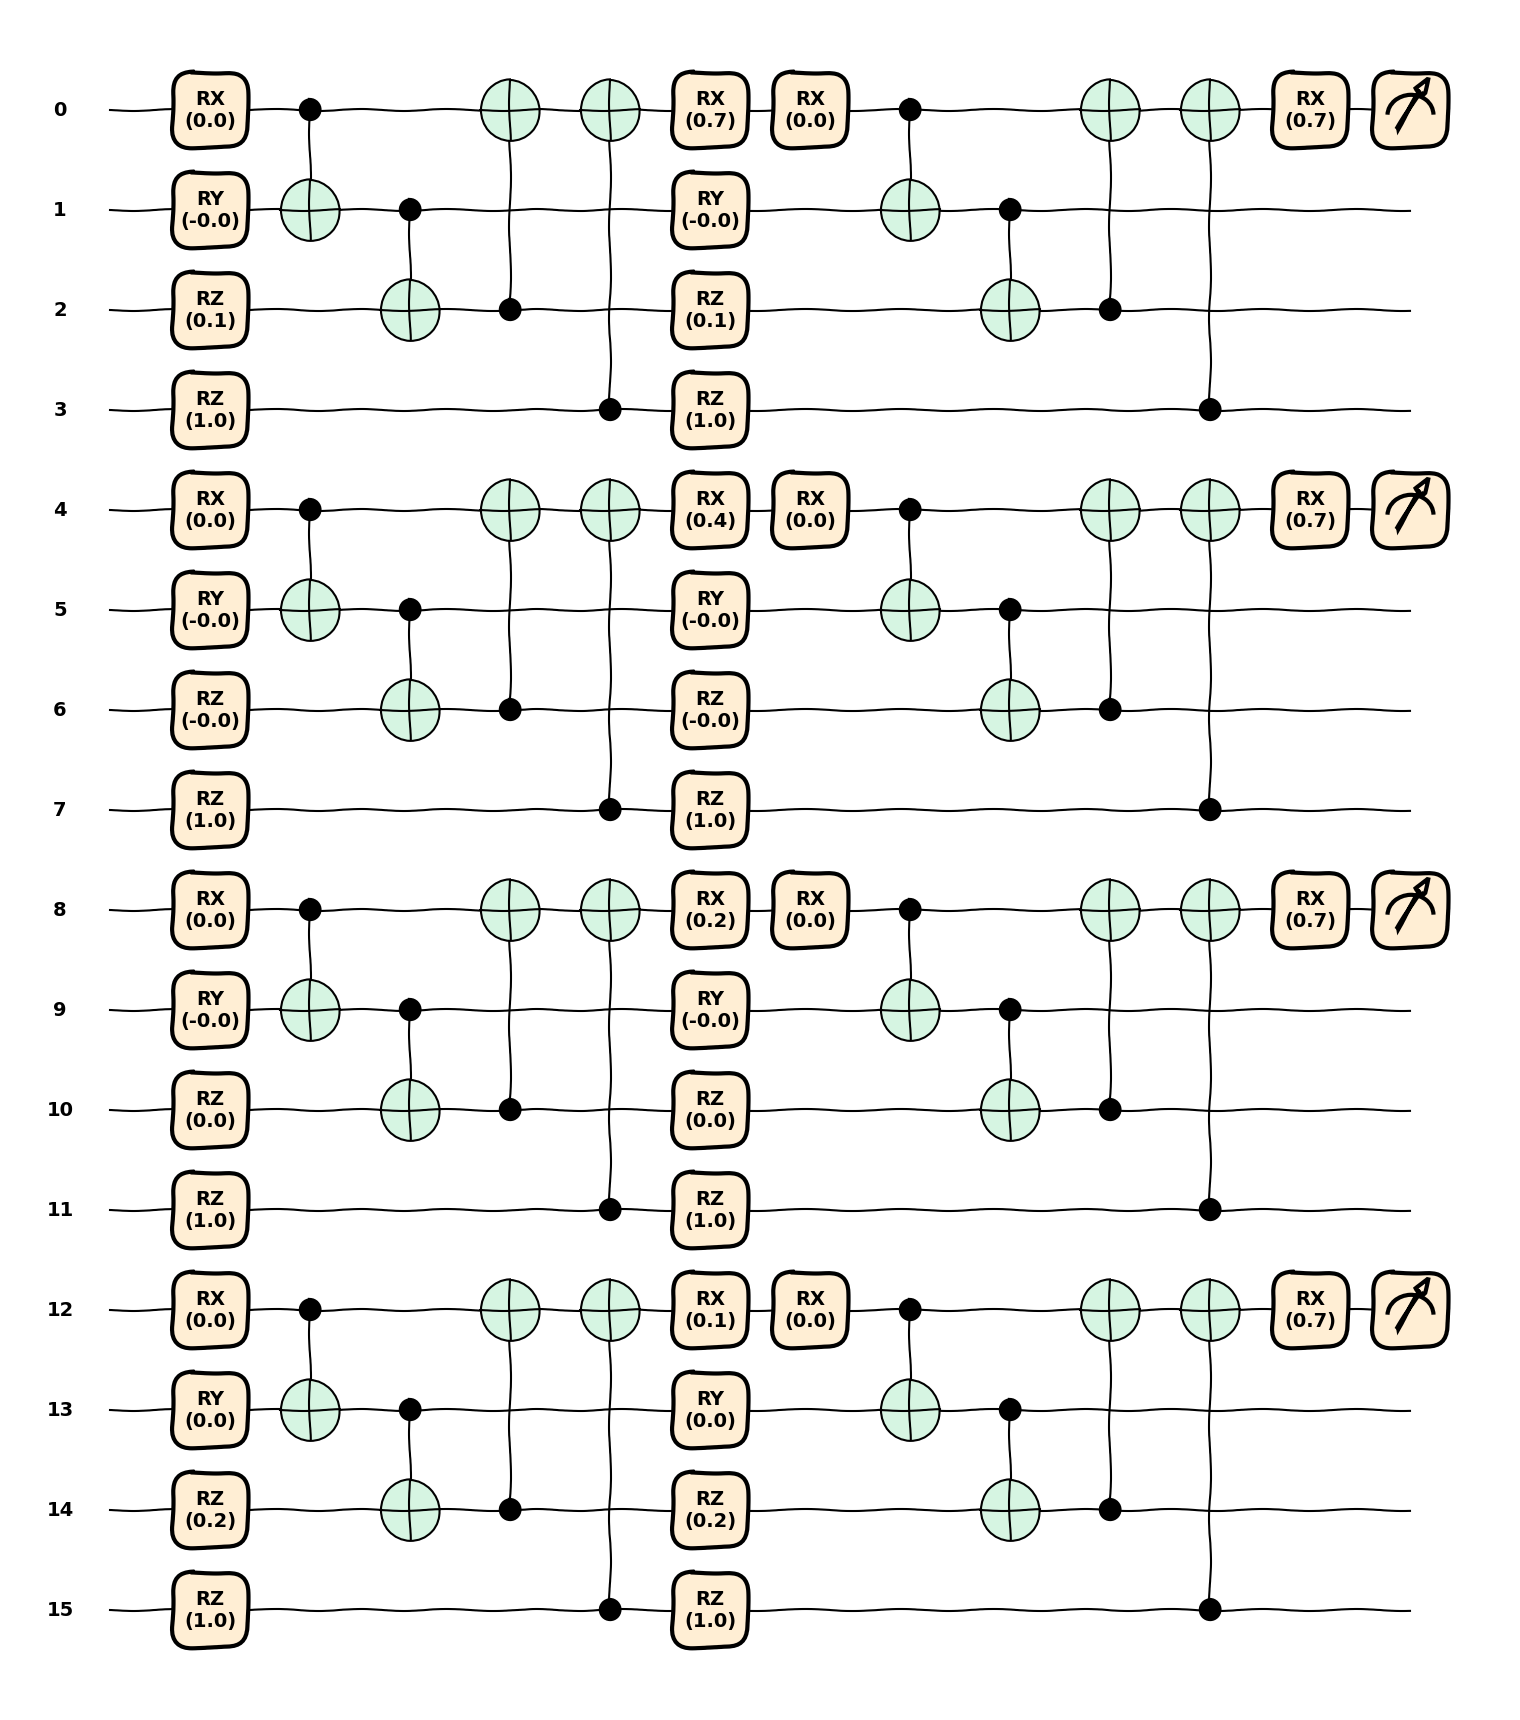

In [20]:
import pennylane as qml
from qiskit.circuit import Parameter
# Create a quantum circuit with Nv qubits
Ne = cut
num_qubits = Ne * 4  # 4 qubits per row (x,y,z,color)
# Define a list of trainable parameters for the entanglement
num_params = cut  # Number of trainable parameters for the entanglement
layers=4
feature = np.random.random(size=(num_params*layers))
def block(X,ansatz,l):
    for i in range(Ne):
        for j in range(4):
            if j==0:
                qml.RX(X[i*4+j], wires = i * 4 + j)
            elif j==1:
                qml.RY(X[i*4+j], wires = i * 4 + j)
            else:
                qml.RZ(X[i*4+j], wires = i * 4 + j)
        #Entangle 3 positions
        qml.CNOT(wires = [i * 4, i * 4 + 1])
        qml.CNOT(wires = [i * 4 + 1, i * 4 + 2])
        qml.CNOT(wires = [i * 4 + 2, i * 4])
        #Entangle color and position-x.
        qml.CNOT(wires = [i * 4 + 3, i * 4])
    for i in range(Ne):
        qml.RX(ansatz[i+Ne*l], wires = i * 4)
def quantum_circuit(X,ansatz):
    block(X,ansatz,0)
    block(X,ansatz,1)
    return [qml.expval(qml.PauliZ(i*4)) for i in range(Ne)]
dev = qml.device("default.qubit", wires=4*Ne)
qnode = qml.QNode(quantum_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(Xs[0],feature)
plt.show()

In [21]:
# Initialize a measurement quantum circuit
def circuit(X, ansatz):
    dev = qml.device('default.qubit', wires=Ne*4)
    @qml.qnode(dev)
    def quantum_circuit(X,ansatz):
        block(X,ansatz,0)
        block(X,ansatz,1)
        return [qml.expval(qml.PauliZ(i*4)) for i in range(Ne)]
    expectations = quantum_circuit(X, ansatz)
    return expectations
#Binary entropy loss function
def binary(x,xp):
    res=[x[i]*np.log(1-xp[i])+(1-x[i])*np.log(xp[i])
        for i in range(len(x)-1)]
    return -(1/(len(x)-1))*sum(res)
def costfunc(params):
    cost = 0
    for i in range(n_samples):
        cost += binary(circuit(Xs[i], params),Ys[i])
    return cost/n_samples
from pennylane import numpy as np
#Initialize trainable parameters
ansatz = np.random.normal(0, 0.1, size=(Ne*layers), requires_grad=True)
#Set-up the optimizer
optimizer = qml.AdamOptimizer(stepsize=0.1)
previous_cost = float('inf')  # Set to a large initial value
# A small threshold to check for convergence
tolerance = 1e-4
#Training start
for k in range(30):
    cost=costfunc(ansatz)
    if k % 3 == 0:
        print(f"Step {k}, cost: {cost}")
    if abs(cost - previous_cost) < tolerance:
        print(f"Converged at step {k}, cost: {cost}")
        break
    ansatz = optimizer.step(costfunc, ansatz)
    previous_cost=cost

Step 0, cost: 1.3967329232529353
Step 3, cost: 1.3926695348317968
Converged at step 3, cost: 1.3926695348317968


In [33]:
#Measure with the fixed parameters
dev = qml.device('default.qubit', wires=Ne*4)
@qml.qnode(dev)
def measure(X,ansatz):
    expect = quantum_circuit(X,ansatz)
    return expect
def zeroOne(arr):
    return [1 if n>0.78 else 0 for n in arr]
for i in range(n_samples):
    result=measure(Xs[i],feature)
    print("Compare ",zeroOne(result[:-1]),
          " with ",Ys_01[i][:-1])

Compare  [1, 0, 0]  with  [1. 0. 0.]
Compare  [1, 0, 0]  with  [0. 0. 0.]
Compare  [1, 0, 0]  with  [0. 0. 0.]
Compare  [1, 0, 0]  with  [1. 1. 0.]
Compare  [1, 0, 0]  with  [0. 1. 0.]
Compare  [1, 0, 0]  with  [1. 0. 0.]
Compare  [1, 0, 0]  with  [0. 1. 0.]
Compare  [1, 0, 0]  with  [0. 1. 0.]
Compare  [1, 0, 0]  with  [0. 1. 0.]
Compare  [1, 0, 0]  with  [1. 0. 0.]
